In [1]:
!pip install gym[atari,accept-rom-license]

In [2]:
import gym
import cv2
import random
from gym import spaces
from collections import deque
import math
from torch.optim import Adam
from torch.nn import MSELoss
import torch
import copy
import random
import numpy as np
import gym
from gym import spaces

cv2.ocl.setUseOpenCL(False)

In [3]:
device = torch.device("cuda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(
                1, self.noop_max + 1
            )  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for i in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"
        assert len(env.unwrapped.get_action_meanings()) >= 6

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work.
        Expects inputs to be of shape height x width x num_channels
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8
        )

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self.width, self.height), interpolation=cv2.INTER_AREA
        )
        return frame[:, :, None]


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        Expects inputs to be of shape num_channels x height x width.
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(shp[0] * k, shp[1], shp[2]), dtype=np.uint8
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._frames)

    def __getitem__(self, i):
        return self._frames[i]


class PyTorchFrame(gym.ObservationWrapper):
    """Image shape to num_channels x height x width"""

    def __init__(self, env):
        super(PyTorchFrame, self).__init__(env)
        shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(shape[-1], shape[0], shape[1]), dtype=np.uint8
        )

    def observation(self, observation):
        return np.rollaxis(observation, 2)


In [6]:
import torch.nn
from gym import spaces
import torch.nn as nn


class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network. The architecture is the same as that described in the
    Nature DQN paper.
    """

    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param observation_space: the state space of the environment
        :param action_space: the action space of the environment
        """
        super().__init__()
        assert (
            type(observation_space) == spaces.Box
        ), "observation_space must be of type Box"
        assert (
            len(observation_space.shape) == 3
        ), "observation space must have the form channels x width x height"
        assert (
            type(action_space) == spaces.Discrete
        ), "action_space must be of type Discrete"

        self.cnn_layer_one = torch.nn.Conv2d(in_channels=4, stride=4, kernel_size=(8, 8), out_channels=32) # output = 32x19x19
        self.cnn_layer_two = torch.nn.Conv2d(in_channels=32, stride=2, kernel_size=(4, 4), out_channels=64) # output = 64x9x9
        self.cnn_layer_three = torch.nn.Conv2d(in_channels=64, stride=1, kernel_size=(3, 3), out_channels=64) # output = 64x7x7
        self.relu_layer = torch.nn.ReLU()

        dummy_input = torch.zeros(1, 4, 84, 84)
        conv_out = self.forward_conv(dummy_input)
        conv_out_shape = int(np.prod(conv_out.shape))

        self.final_hidden_layer = torch.nn.Linear(in_features=conv_out_shape, out_features=512)
        self.final_layer = torch.nn.Linear(in_features=512, out_features=action_space.n)


    def forward_conv(self, x):
        x = self.relu_layer(self.cnn_layer_one(x))
        x = self.relu_layer(self.cnn_layer_two(x))
        x = self.relu_layer(self.cnn_layer_three(x))
        return x

    def forward(self, x):
        x = x.cuda()
        x = self.forward_conv(x=x)
        x = x.view(x.size(0), -1)

        final_hidden_output = self.final_hidden_layer(x)
        relu_flattened = self.relu_layer(final_hidden_output)

        output = self.final_layer(relu_flattened)
        output = output.cuda()

        return output

In [7]:

class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return {
            "state": np.array(states),
            "action": np.array(actions),
            "reward": np.array(rewards),
            "next_state": np.array(next_states),
            "done": np.array(dones),
        }

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices), indices

In [8]:

class DQNAgent:
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """
        self.dqn_model = DQN(
            observation_space=observation_space,
            action_space=action_space
        )
        self.dqn_model = self.dqn_model.cuda()
        self.target_dqn = copy.deepcopy(self.dqn_model)
        self.target_dqn = self.target_dqn.cuda()
        self.optimizer = Adam(self.dqn_model.parameters(), lr=lr)
        self.loss_fn = MSELoss()
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size


    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        replay_entries, mini_batch_size = self.replay_buffer.sample(self.batch_size)

        state = torch.tensor(replay_entries["state"], dtype=torch.float32).to(device)
        next_state = torch.tensor(replay_entries["next_state"], dtype=torch.float32).to(device)
        reward = torch.tensor(replay_entries["reward"], dtype=torch.float32).to(device)
        done = torch.tensor(replay_entries["done"], dtype=torch.float32).to(device)

        q_target = self.target_dqn(next_state).max(dim=1)[0]
        q_target = q_target.cuda()
        y_j = reward
        y_j += (1 - done) * self.gamma * q_target

        predict = self.dqn_model(state).to(device).gather(dim=1, index=torch.tensor(replay_entries["action"]).to(device).unsqueeze(-1)).squeeze()

        self.optimizer.zero_grad()
        loss = self.loss_fn(predict, y_j)
        loss.backward()
        self.optimizer.step()

        return loss


    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_dqn = copy.deepcopy(self.dqn_model)
        self.target_dqn = self.target_dqn.cuda()

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        state_value = state.__array__().astype('float32')
        tensor_state = torch.from_numpy(state_value)
        reshaped_tensor = torch.reshape(tensor_state, (1, 4, 84, 84))
        reshaped_tensor.to(device)
        output_action = self.dqn_model(reshaped_tensor).to(device)
        action = torch.argmax(output_action)
        action_value = torch.max(output_action)
        return action.item(), action_value.item()

In [9]:


hyper_params = {
    "seed": 42,  # which seed to use
    "env": "PongNoFrameskip-v4",  # name of the game
    "replay-buffer-size": int(5e4),  # replay buffer size
    "learning-rate": 1e-4,  # learning rate for Adam optimizer
    "discount-factor": 0.99,  # discount factor
    "num-steps": int(1e6),  # total number of steps to run the environment for
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 1,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.1,  # fraction of num-steps
    "print-freq": 1,
}

for item in hyper_params:
  print(f"{item}: {hyper_params[item]}")

np.random.seed(hyper_params["seed"])
random.seed(hyper_params["seed"])

assert "NoFrameskip" in hyper_params["env"], "Require environment with no frameskip"
env = gym.make(hyper_params["env"], full_action_space=False)
env.seed(hyper_params["seed"])

env = NoopResetEnv(env, noop_max=30)
env = MaxAndSkipEnv(env, skip=4)
env = EpisodicLifeEnv(env)
env = FireResetEnv(env)
env = WarpFrame(env)
env = PyTorchFrame(env)
env = FrameStack(env, 4)

replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

agent = DQNAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    replay_buffer=replay_buffer,
    use_double_dqn=False,
    lr=hyper_params["learning-rate"],
    batch_size=hyper_params["batch-size"],
    gamma=0.99
)

eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
episode_rewards = [0.0]

state = env.reset()
losses = []
episode_losses = []
action_values = []
episode_action_values = []
for t in range(hyper_params["num-steps"]):
    fraction = min(1.0, float(t) / eps_timesteps)
    eps_threshold = hyper_params["eps-start"] + fraction * (
        hyper_params["eps-end"] - hyper_params["eps-start"]
    )
    sample = random.random()
    if sample < eps_threshold:
        action = torch.tensor(random.randint(0, 5))
    else:
        action, action_value = agent.act(state)
        action_values.append(action_value)
    next_state, reward, done, info = env.step(action)
    agent.replay_buffer.add(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done
    )

    episode_rewards[-1] += reward
    if done:
        print(f"episode {len(episode_rewards)} done")
        episode_action_values.append(np.mean(action_values))
        if losses:
          episode_losses.append(np.mean(losses))
        action_values = []
        losses = []
        state = env.reset()
        episode_rewards.append(0.0)

    if (
        t > hyper_params["learning-starts"]
        and t % hyper_params["learning-freq"] == 0
    ):
        loss = agent.optimise_td_loss()
        losses.append(loss.item())

    if (
        t > hyper_params["learning-starts"]
        and t % hyper_params["target-update-freq"] == 0
    ):
        agent.update_target_network()

    num_episodes = len(episode_rewards)
    state = next_state

    if (
        done
        and hyper_params["print-freq"] is not None
        and len(episode_rewards) % hyper_params["print-freq"] == 0
    ):
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print(f"Episode return: {episode_rewards[-2]}")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% time spent exploring: {}".format(int(100 * eps_threshold)))
        print("********************************************************")



seed: 42
env: PongNoFrameskip-v4
replay-buffer-size: 50000
learning-rate: 0.0001
discount-factor: 0.99
num-steps: 1000000
batch-size: 64
learning-starts: 1000
learning-freq: 1
use-double-dqn: True
target-update-freq: 100
eps-start: 1.0
eps-end: 0.01
eps-fraction: 0.1
print-freq: 1


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


episode 1 done
********************************************************
Episode return: -21.0
steps: 776
episodes: 2
mean 100 episode reward: -21.0
% time spent exploring: 99
********************************************************
episode 2 done
********************************************************
Episode return: -20.0
steps: 1694
episodes: 3
mean 100 episode reward: -20.5
% time spent exploring: 98
********************************************************
episode 3 done
********************************************************
Episode return: -20.0
steps: 2607
episodes: 4
mean 100 episode reward: -20.3
% time spent exploring: 97
********************************************************
episode 4 done
********************************************************
Episode return: -21.0
steps: 3490
episodes: 5
mean 100 episode reward: -20.5
% time spent exploring: 96
********************************************************
episode 5 done
******************************************************

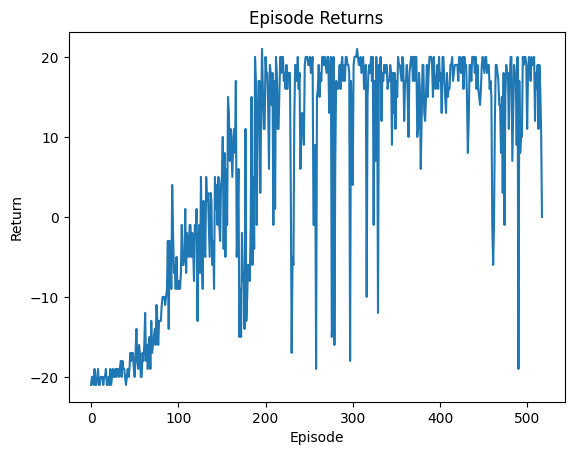

In [19]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(episode_rewards))], episode_rewards)
plt.title('Episode Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

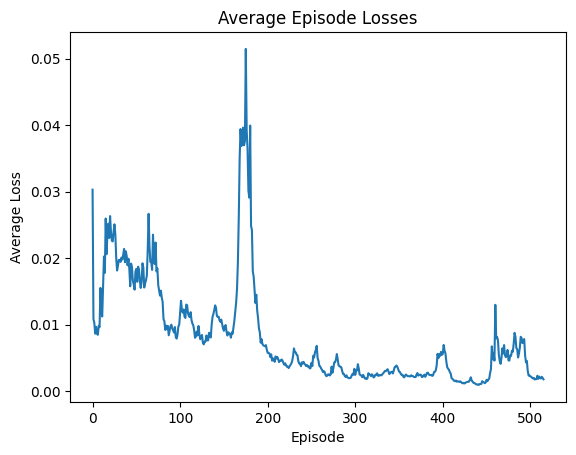

In [20]:
plt.plot([i for i in range(len(episode_losses))], episode_losses)
plt.title('Average Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.show()

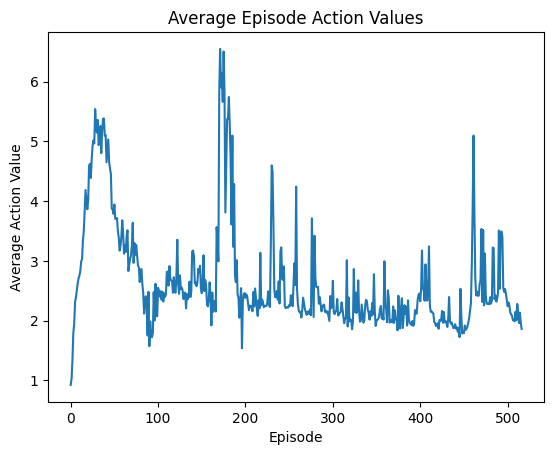

In [21]:
plt.plot([i for i in range(len(episode_action_values))], episode_action_values)
plt.title('Average Episode Action Values')
plt.xlabel('Episode')
plt.ylabel('Average Action Value')
plt.show()

In [22]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [29]:
hyper_params = {
    "seed": 42,  # which seed to use
    "env": "PongNoFrameskip-v4",  # name of the game
    "replay-buffer-size": int(5e4),  # replay buffer size
    "learning-rate": 1e-4,  # learning rate for Adam optimizer
    "discount-factor": 0.99,  # discount factor
    "num-steps": int(1e6),  # total number of steps to run the environment for
    "batch-size": 64,  # number of transitions to optimize at the same time
    "learning-starts": 1000,  # number of steps before learning starts
    "learning-freq": 1,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 100,  # number of iterations between every target network update
    "eps-start": 0,  # e-greedy start threshold
    "eps-end": 0,  # e-greedy end threshold
    "eps-fraction": 0,  # fraction of num-steps
    "print-freq": 1,
}

for item in hyper_params:
  print(f"{item}: {hyper_params[item]}")

np.random.seed(hyper_params["seed"])
random.seed(hyper_params["seed"])

assert "NoFrameskip" in hyper_params["env"], "Require environment with no frameskip"
env = gym.make(hyper_params["env"], full_action_space=False)

filePath = "testVid5.mp4"
video = VideoRecorder(env, filePath)

env = NoopResetEnv(env, noop_max=30)
env = MaxAndSkipEnv(env, skip=4)
env = EpisodicLifeEnv(env)
env = FireResetEnv(env)
env = WarpFrame(env)
env = PyTorchFrame(env)
env = FrameStack(env, 4)

state = env.reset()

for t in range(hyper_params["num-steps"]):
    video.capture_frame()
    action, action_value = agent.act(state)
    next_state, reward, done, info = env.step(action)
    if done:
        break
    state = next_state

video.close()
env.close()

seed: 42
env: PongNoFrameskip-v4
replay-buffer-size: 50000
learning-rate: 0.0001
discount-factor: 0.99
num-steps: 1000000
batch-size: 64
learning-starts: 1000
learning-freq: 1
use-double-dqn: True
target-update-freq: 100
eps-start: 0
eps-end: 0
eps-fraction: 0
print-freq: 1


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment PongNoFrameskip-v4 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <cl